## Proyecto 3. Entrega 3
### LSTM
Diego Duarte 22075 - José Marchena 22398 - Andrés Kou 22305 - Esteban Zambrano 22119

In [1]:
import pandas as pd
import LSTM
import numpy as np

# Cargar el archivo CSV
csv_path = "../DataFinal.csv"
df = pd.read_csv(csv_path)

In [2]:
n_lags = 3  # Usaremos los 3 años previos
X, y = LSTM.preparar_series_lstm(df, n_lags)

# Revisar las dimensiones de X e y
print(X.shape)  # Esto debería ser (n_samples, 3, n_features)
print(y.shape) 




(114, 3, 20)
(114,)


In [3]:
from sklearn.model_selection import train_test_split

# Dividir en entrenamiento y prueba (sin mezclar las secuencias)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=61023521)

# Ver las formas de los datos
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(91, 3, 20) (23, 3, 20)
(91,) (23,)


In [4]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Normalizar X_train, X_test, y_train, y_test
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1]))
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1]))

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Convertir los datos normalizados a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).view(-1, X_train.shape[1], X_train.shape[2])
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).view(-1, X_test.shape[1], X_test.shape[2])
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Crear dataloaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [6]:
# Definir parámetros
input_size = X_train.shape[2]  # El número de características (columnas de VI)
hidden_size = 64  # Puedes ajustar este valor
num_layers = 2  # Puedes ajustar este valor

# Inicializar el modelo
model = LSTM.LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

# Definir la función de pérdida (MSE) y el optimizador (Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
num_epochs = 50  # Número de épocas
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


for epoch in range(num_epochs):
    model.train()  # Establecer el modelo en modo entrenamiento
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Enviar los datos a GPU si está disponible
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Reiniciar los gradientes de los optimizadores
        optimizer.zero_grad()

        # Hacer una predicción
        outputs = model(inputs)

        # Calcular la pérdida
        loss = criterion(outputs, labels)
        
        # Propagar hacia atrás (backpropagation)
        loss.backward()
        
        # Actualizar los parámetros
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/50], Loss: 1.0110
Epoch [2/50], Loss: 0.9629
Epoch [3/50], Loss: 0.9133
Epoch [4/50], Loss: 0.8538
Epoch [5/50], Loss: 0.7777
Epoch [6/50], Loss: 0.6807
Epoch [7/50], Loss: 0.5629
Epoch [8/50], Loss: 0.4330
Epoch [9/50], Loss: 0.3096
Epoch [10/50], Loss: 0.2168
Epoch [11/50], Loss: 0.1654
Epoch [12/50], Loss: 0.1317
Epoch [13/50], Loss: 0.0904
Epoch [14/50], Loss: 0.0529
Epoch [15/50], Loss: 0.0353
Epoch [16/50], Loss: 0.0306
Epoch [17/50], Loss: 0.0251
Epoch [18/50], Loss: 0.0186
Epoch [19/50], Loss: 0.0161
Epoch [20/50], Loss: 0.0156
Epoch [21/50], Loss: 0.0139
Epoch [22/50], Loss: 0.0121
Epoch [23/50], Loss: 0.0111
Epoch [24/50], Loss: 0.0104
Epoch [25/50], Loss: 0.0096
Epoch [26/50], Loss: 0.0089
Epoch [27/50], Loss: 0.0084
Epoch [28/50], Loss: 0.0080
Epoch [29/50], Loss: 0.0076
Epoch [30/50], Loss: 0.0072
Epoch [31/50], Loss: 0.0071
Epoch [32/50], Loss: 0.0070
Epoch [33/50], Loss: 0.0068
Epoch [34/50], Loss: 0.0067
Epoch [35/50], Loss: 0.0065
Epoch [36/50], Loss: 0.0063
E

In [8]:
model.eval()  # Establecer el modelo en modo evaluación
with torch.no_grad():  # No necesitamos calcular los gradientes durante la evaluación
    y_pred = []
    y_true = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Hacer predicción
        outputs = model(inputs)
        
        # Almacenar las predicciones y los valores verdaderos
        y_pred.append(outputs.cpu().numpy())
        y_true.append(labels.cpu().numpy())
    
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)

# Comparar las predicciones con los valores verdaderos
print(f"Predicciones: {y_pred[:5]}")
print(f"Valores reales: {y_true[:5]}")


Predicciones: [[ 0.55339384]
 [-0.18688457]
 [-0.7383934 ]
 [-1.00299   ]
 [-1.0825814 ]]
Valores reales: [[ 0.35792658]
 [-0.29539424]
 [-0.8298666 ]
 [-1.041411  ]
 [-1.0556492 ]]


### SVM

In [9]:
# Juntar la data de los ultimos años
X_all, y_all = LSTM.preparar_series_lstm(df, 10)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, 
    test_size=0.2, 
    shuffle=False, 
    random_state=61023521)
X_train = X_train.reshape(85,-1)
X_test = X_test.reshape(22,-1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(85, 200) (85,)
(22, 200) (22,)


In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from pipeline import crear_pipeline_svm

svm = crear_pipeline_svm(SVR(kernel='linear'))
svm.fit(X_train, y_train)
y_svm = svm.predict(X_test)

In [11]:
import error_metrics
error_metrics.calculate_errors(y_svm, y_test, "SVR")

SVR:
MAE: 28173.901243124154
MSE: 1047549304.3330089
RMSE: 32365.866346090737
R²: 0.17789834323877907


In [12]:
print(svm.get_params())

{'memory': None, 'steps': [('imputer', SimpleImputer()), ('scaler', StandardScaler()), ('model', SVR(kernel='linear'))], 'transform_input': None, 'verbose': False, 'imputer': SimpleImputer(), 'scaler': StandardScaler(), 'model': SVR(kernel='linear'), 'imputer__add_indicator': False, 'imputer__copy': True, 'imputer__fill_value': None, 'imputer__keep_empty_features': False, 'imputer__missing_values': nan, 'imputer__strategy': 'mean', 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'model__C': 1.0, 'model__cache_size': 200, 'model__coef0': 0.0, 'model__degree': 3, 'model__epsilon': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear', 'model__max_iter': -1, 'model__shrinking': True, 'model__tol': 0.001, 'model__verbose': False}


In [13]:
from sklearn.model_selection import GridSearchCV
svm_opt = crear_pipeline_svm(SVR())
param_grid = {
    'model__kernel': ['linear','poly', 'rbf'],
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__epsilon': [0.1, 0.5, 1.0],
    'model__degree': [2, 3, 4], 
    'model__gamma': ['scale', 'auto']
}

gs = GridSearchCV(
    svm_opt,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

gs.fit(X_train, y_train)
best_model_svr= gs.best_estimator_
print("Best Params: ",gs.best_params_)
best_rmse = np.sqrt(-gs.best_score_)
print("Best RMSE", best_rmse)

Best Params:  {'model__C': 100, 'model__degree': 2, 'model__epsilon': 1.0, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Best RMSE 3679.930938348204


SVR opt:
MAE: 5134.151034395237
MSE: 41731129.49340138
RMSE: 6459.963582977955
R²: 0.9672500086123523


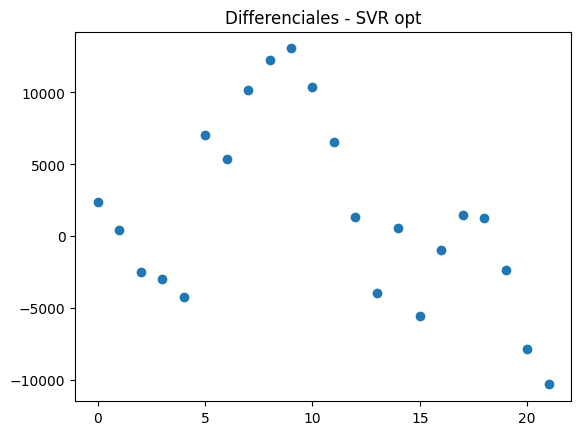

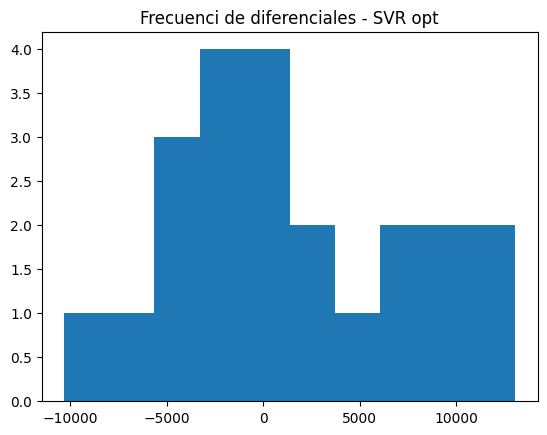

In [14]:
y_best_svr = best_model_svr.predict(X_test)
error_metrics.calculate_errors(y_best_svr, y_test, "SVR opt")
error_metrics.diff_analysis(y_best_svr, y_test, "SVR opt")

## Random Forest

Random Forest:
MAE: 3837.433636363636
MSE: 26723327.014918182
RMSE: 5169.460998490866
R²: 0.9790279165646295


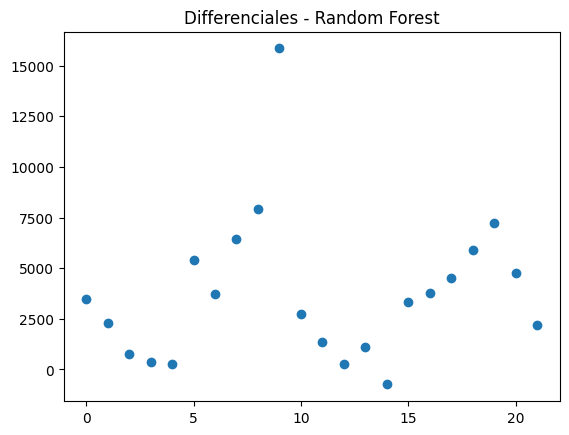

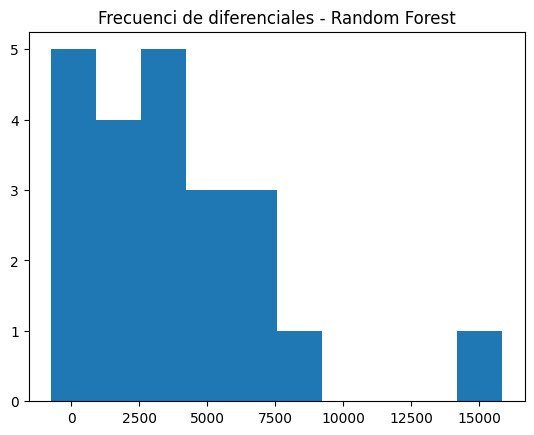

In [16]:
from sklearn.ensemble import RandomForestRegressor
from pipeline import crear_pipeline_random_forest

rnd_fst = crear_pipeline_svm(RandomForestRegressor())
rnd_fst.fit(X_train, y_train)
y_rf = rnd_fst.predict(X_test)
error_metrics.calculate_errors(y_rf, y_test, "Random Forest")
error_metrics.diff_analysis(y_rf, y_test, "Random Forest")